In [1]:
# Exploratory Data Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [3]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# and reset all the datatypes to the expected types.
# df.race = df.race.astype('category')
# df.gender = df.gender.astype('category')
# df.facility = df.facility.astype('category')
# df.detainer = df.detainer.astype('category')
# df.offense_class = df.offense_class.astype('category')

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 798 days in our dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted, we'll cap the days at 1,163 (798 + 365).  This is definitely going to need
# further investigation.
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1163 else 1163 for time in df.days]

df['tens'] = [int((age // 10) * 10) for age in df.age] 

# Check that everything worked.  In this EDA, there should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 14 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28808 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
tens                     28808 non-null int64
dtypes: datetime64[ns](2), int64(5), object(7)
memory usage: 3.1+ MB


In [4]:
# Separate out the two datasets, misdemeanor (primary) and felony.
felony_df = df.loc[df['offense_class'].str.endswith('F')]
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

# Bin edges to more easily see age differences.
bin_edges = [10, 20, 30, 40, 50, 60, 70, 80, 90] 

# Bin edges for non-age plots.  Sqrt to avoid 'bin bias.'
bins_sqrt = int(np.sqrt(len(misdemeanor_df.bond_amount))) 

# Set up an ecdf function to quickly see distributions.
def ecdf(data):
    '''Compute emperical distribution function for one column'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# And for reference, the number of bins in non-age plots:
bins_sqrt

98

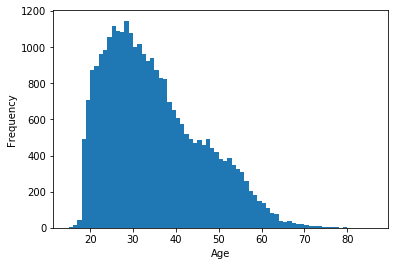

32.0

In [5]:
# Plot the ages and ecdf of ages over the entire dataframe, just to see
# what we're starting with.
df_bins = df.age.max() - df.age.min() # Comes to 71, one for each age in sample
ax = df.age.plot(kind='hist', bins=df_bins)
ax = plt.xlabel('Age')
ax = plt.ylabel('Frequency')
plt.show()
df.age.median()

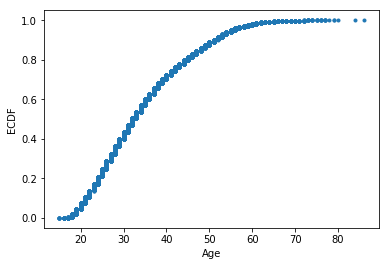

In [6]:
x_age, y_age = ecdf(df.age)
ax = plt.plot(x_age, y_age, marker='.', linestyle='none')
ax = plt.xlabel('Age')
ax = plt.ylabel('ECDF')
plt.show()

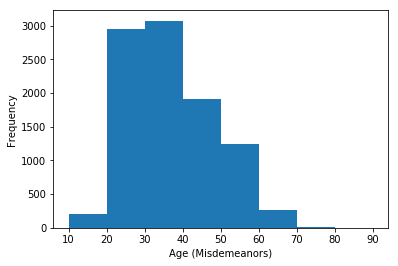

34.0

In [7]:
# Now, plot the ages and ecdf of the ages for misdemeanor detainees.  
# Bins are decades for now.
ax = misdemeanor_df.age.plot(kind='hist', bins=bin_edges)
ax = plt.xlabel('Age (Misdemeanors)')
ax = plt.ylabel('Frequency')
plt.show()
misdemeanor_df.age.median()

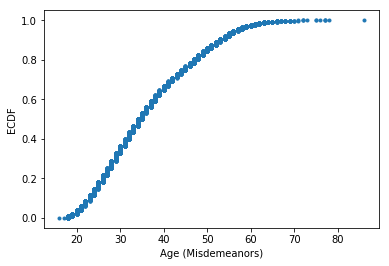

In [8]:
x_age, y_age = ecdf(misdemeanor_df.age)
ax = plt.plot(x_age, y_age, marker='.', linestyle='none')
ax = plt.xlabel('Age (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

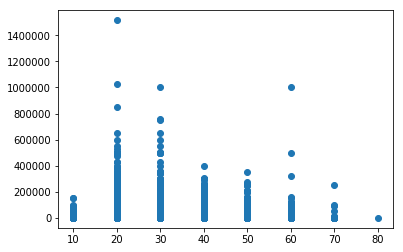

In [9]:
# Quick plot where bonds is checked against ages in decades to check for anything
# interesting.  
_ = plt.scatter(misdemeanor_df.tens, misdemeanor_df.bond_amount)

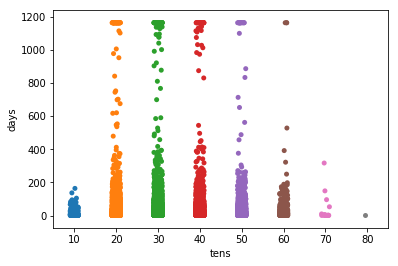

In [10]:
# Quick plots where days detained is checked against ages in decades.
_ = sns.stripplot(misdemeanor_df.tens, misdemeanor_df.days)

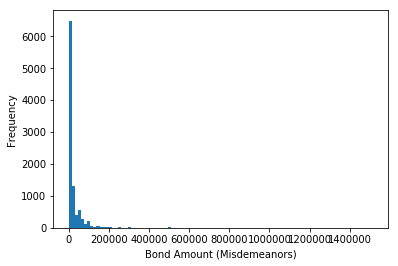

In [11]:
# Plot the misdemeanor bonds.  Most bonds are obviously below 200k.
# We'll look at a zoom later.
ax = misdemeanor_df.bond_amount.plot(kind='hist', bins=bins_sqrt)
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('Frequency')
plt.show()

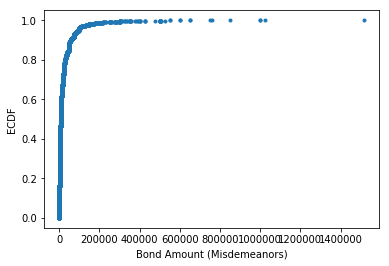

In [12]:
x_bond, y_bond = ecdf(misdemeanor_df.bond_amount)
ax = plt.plot(x_bond, y_bond, marker='.', linestyle='none')
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

In [13]:
# How many of bond amounts are significantly higher?
len(misdemeanor_df.loc[misdemeanor_df.bond_amount >= 400000])

33

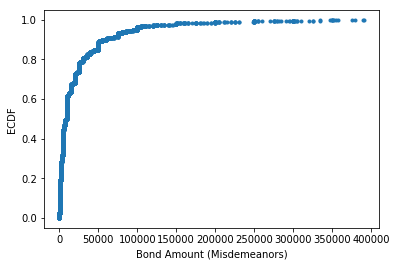

In [14]:
# Check ECDF without those high bonds.  Almost all the bonds are below 80,000.
x_bond, y_bond = ecdf(misdemeanor_df.bond_amount)
x_bond = x_bond[:-33]
y_bond = y_bond[:-33]
ax = plt.plot(x_bond, y_bond, marker='.', linestyle='none')
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

In [15]:
# How many of bond amounts are below 80,000?
len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000])

9046

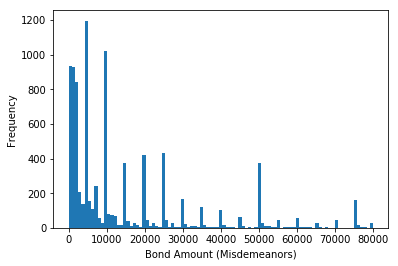

In [16]:
# Not pretty, but shows that bonds are frequently set at numbers divisible by 0 and 5.
bins_80k = int(np.sqrt(len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000])))
plot_80k_df = misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000]
ax = plot_80k_df.bond_amount.plot(kind='hist', bins=bins_80k)
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('Frequency')

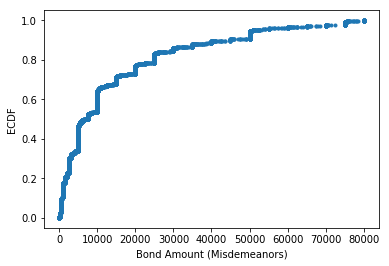

In [17]:
x_bond_80k, y_bond_80k = ecdf(plot_80k_df.bond_amount)
ax = plt.plot(x_bond_80k, y_bond_80k, marker='.', linestyle='none')
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

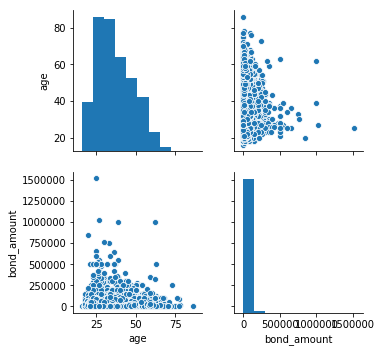

In [18]:
sns.pairplot(misdemeanor_df, vars=['age', 'bond_amount'])

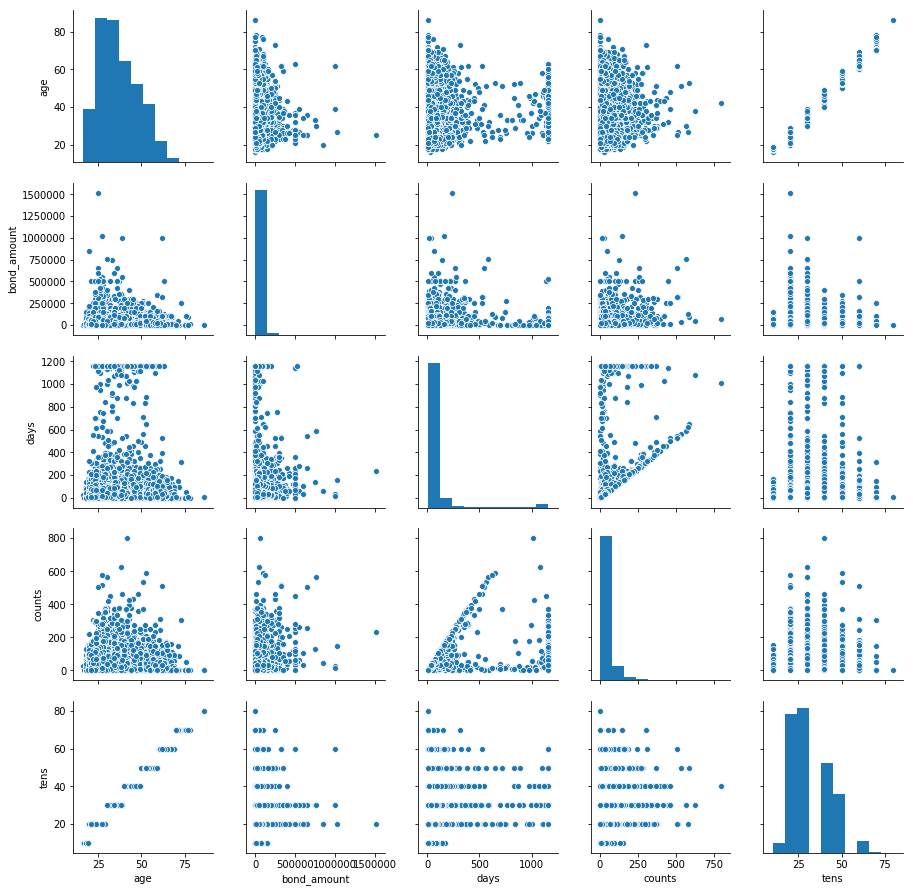

In [19]:
# Just an overview of all the relationships.  The counts vs. days plots are 
# interesting.  Counts is the number of times a detainee is observed in the 
# dataset.  This will obviously be skewed low for anyone already in the system 
# on 2016-07-01, but the state admits that the days calculation (using 
# latest_admission_date) might be the original date the detainee was entered 
# into the CT system instead of the date of entry of this offense.  (Reminder, 
# days is capped at 1,136.)
sns.pairplot(misdemeanor_df)

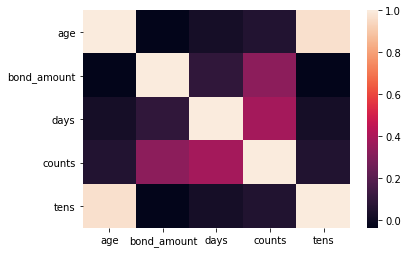

In [20]:
# A heatmap to show correlation between the variables.  Mild correlation
# at most.
corr = misdemeanor_df.corr()
_ = sns.heatmap(corr)

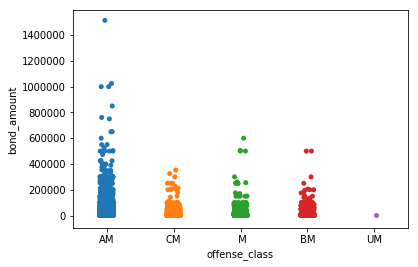

In [21]:
# Now check into the distribution of charges and bond amounts.
# A-class misdemeanors (highest level) show higher - or at least more 
# varied - bonds.
ax = sns.stripplot(x='offense_class', y='bond_amount', data=misdemeanor_df)

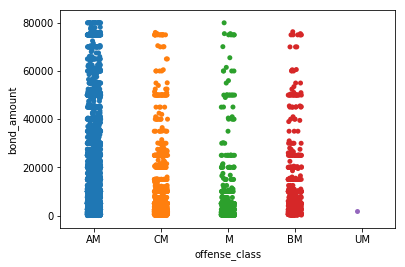

In [22]:
# Zoom of the above plot using the <= 80k dataframe.  A-class misdemeanors are
# more diverse.
ax = sns.stripplot(x='offense_class', y='bond_amount', data=plot_80k_df)

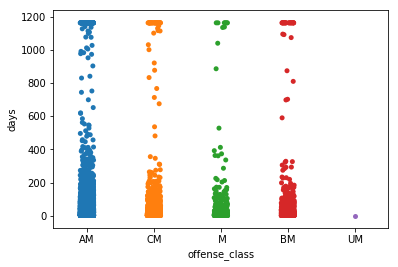

In [23]:
# Offense class vs. days detained.  A-class appears to spend more time
# in custody before bonding out or going to trial.
ax = sns.stripplot(x='offense_class', y='days', data=misdemeanor_df)

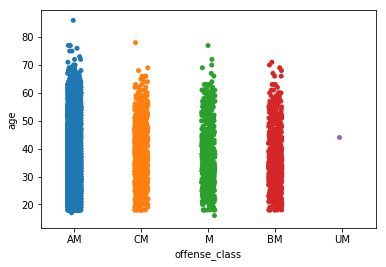

In [24]:
# Offense class vs. age.  I am a little surprised.  I thought the higher
# offenses would skew younger, but maybe the number of offenses is playing
# percerption tricks.
ax = sns.stripplot(x='offense_class', y='age', data=misdemeanor_df)

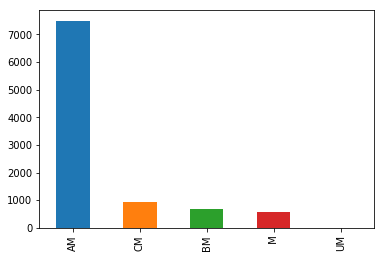

In [25]:
# Counts per offense class.  A-class misdemeanors account for the majority 
# of the sample.  This is why the strip plot for AM is more difficult to 
# make assumptions about.
_ = misdemeanor_df['offense_class'].value_counts().plot(kind='bar')

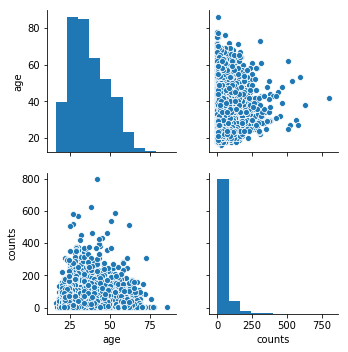

In [26]:
# Age vs. counts.  Older people appear to be released sooner.
sns.pairplot(misdemeanor_df, vars=['age', 'counts'])

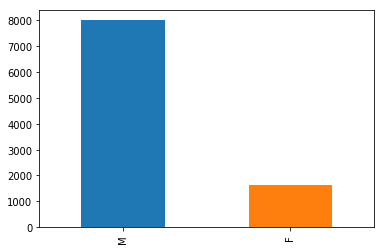

In [27]:
# Count how many for male/female.
_ = misdemeanor_df['gender'].value_counts().plot(kind='bar')

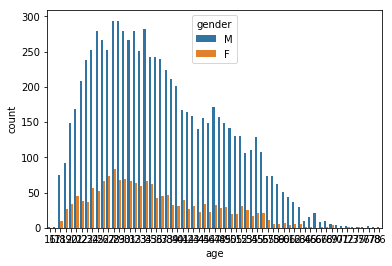

In [28]:
# Compare the ages for both genders in the sample.
_ = sns.countplot(x='age', hue='gender', data=misdemeanor_df)

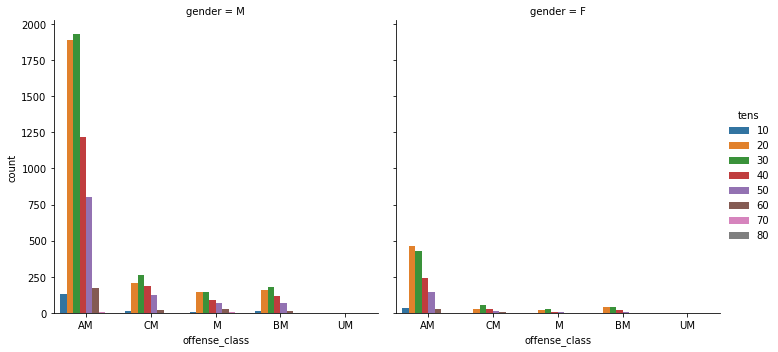

In [29]:
# Check gender distributions of the offense classes against ages in decades.
_ = sns.catplot(x="offense_class", hue="tens", data=misdemeanor_df, kind='count', col='gender');

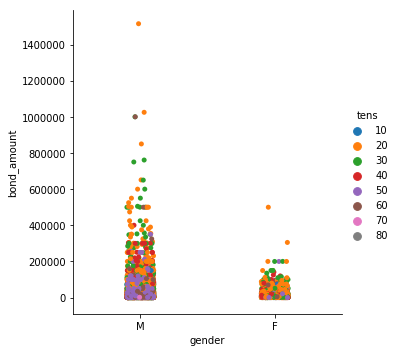

In [30]:
# Check gender distributions of the bond amounts against ages in decades.
# Bonds for female detainees seem to fall more in line with the entire sample
# bond graph that showed that most bonds were below 100k.
_ = sns.catplot(x="gender", hue="tens", data=misdemeanor_df, y='bond_amount');

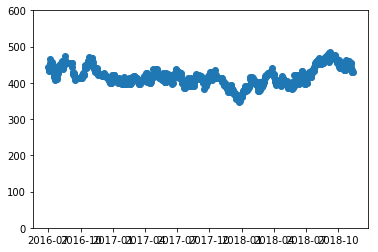

In [31]:
# This block is entirely to get a count of the misdemeanor detainees the state
# claims to hold each day to see if the number changes.

# Select the file created in CT_csv (unit 5 data wrangling assignment)
temp_file = 'count.csv'
# Read in the file
counts_df = pd.read_csv(temp_file, parse_dates=['download_date'])
counts_df.drop_duplicates(inplace=True)
# Set the dates and new df.
datelist = pd.date_range(start='7/1/2016', end='11/11/2018', freq='D').tolist()
dates_df = pd.DataFrame({'date':datelist})
# Separate out the Ms and count them.
mis_df = counts_df.loc[counts_df.offense_class.str.endswith('M', na=False)] 
dates_df['detainees'] = [mis_df.download_date.loc[mis_df.download_date == date].count() 
                         if mis_df.download_date.loc[mis_df.download_date == date].count() > 0
                         else np.nan for date in dates_df.date]
dates_df['detainees'] = dates_df['detainees'].fillna(method='ffill')
dates_df['date_ordinal'] = pd.to_datetime(dates_df['date']).apply(lambda date: date.toordinal())

_ = plt.plot_date(x='date', y='detainees', data=dates_df)
_ = plt.ylim(0, 600)

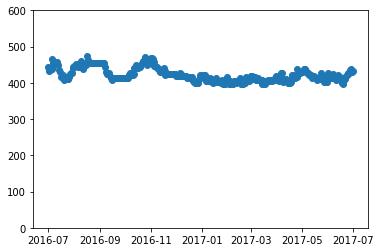

In [32]:
# Check the pre-bill dates on zoom.

pre_dates_df = dates_df.loc[dates_df.date < '2017-07-01']
_ = plt.plot_date(x='date', y='detainees', data=pre_dates_df)
_ = plt.ylim(0, 600)

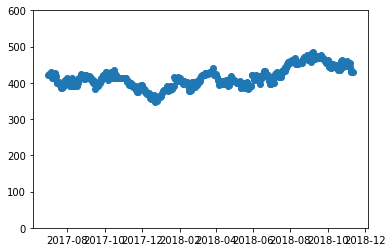

In [33]:
# Check the post-bill dates on zoom.  After looking at these, I don't
# have a visual understanding of if the bill changed anything.  (It does 
# appear that the first year after the bill was lower, but that changes
# about thirteen months after passage.)

post_dates_df = dates_df.loc[dates_df.date >= '2017-07-01']
_ = plt.plot_date(x='date', y='detainees', data=post_dates_df)
_ = plt.ylim(0, 600)